## Machine Learning task of predicting the severity of a commit based on it's message, time and personal information

# Data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
pd.set_option('max_columns',25)
pd.set_option('max_rows',100)

In [2]:
commits = pd.read_csv('commits.csv')
issues = pd.read_csv('issues.csv')

In [3]:
dataset = commits.merge(issues,on='key',how='left')

In [4]:
dataset.drop(dataset.columns.difference(['author_name','author_email','committer_name',
                                         'committer_email','time','time_offset',
                                         'message_encoding','severity']), 1, inplace=True)
dataset.head(10)

,author_name,author_email,committer_name,committer_email,time,time_offset,message_encoding,severity
0,gatorsmile,gatorsmile@gmail.com,Reynold Xin,rxin@databricks.com,1478510197,-480,[SPARK-16904][SQL] Removal of Hive Built-in Ha...,3.0
1,Reynold Xin,rxin@databricks.com,Reynold Xin,rxin@databricks.com,1478501095,-480,[SPARK-18296][SQL] Use consistent naming for e...,3.0
2,Reynold Xin,rxin@databricks.com,Reynold Xin,rxin@databricks.com,1478500925,-480,[SPARK-18167][SQL] Disable flaky hive partitio...,3.0
3,Wenchen Fan,wenchen@databricks.com,Reynold Xin,rxin@databricks.com,1478487433,-480,[SPARK-18173][SQL] data source tables should s...,3.0
4,hyukjinkwon,gurwls223@gmail.com,Reynold Xin,rxin@databricks.com,1478487125,-480,[SPARK-18269][SQL] CSV datasource should read ...,3.0
5,Wojciech Szymanski,wk.szymanski@gmail.com,Yanbo Liang,ybliang8@gmail.com,1478446993,-480,[SPARK-18210][ML] Pipeline.copy does not creat...,1.0
6,hyukjinkwon,gurwls223@gmail.com,Sean Owen,sowen@cloudera.com,1478441497,0,[SPARK-17854][SQL] rand/randn allows null/long...,1.0
7,sethah,seth.hendrickson16@gmail.com,Yanbo Liang,ybliang8@gmail.com,1478410687,-420,[SPARK-18276][ML] ML models should copy the tr...,1.0
8,hyukjinkwon,gurwls223@gmail.com,Felix Cheung,felixcheung@apache.org,1478407653,-420,[MINOR][DOCUMENTATION] Fix some minor descript...,NaN
9,Susan X. Huynh,xhuynh@mesosphere.com,Sean Owen,sowen@cloudera.com,1478367915,0,[SPARK-17964][SPARKR] Enable SparkR with Mesos...,1.0


In [5]:
print('Author emails: %r\n Author names: %r'%(len(dataset.author_email.value_counts()),
                                               len(dataset.author_name.value_counts())))

Author emails: 1378
 Author names: 1310


In [6]:
print('Committer emails: %r\n Committer names: %r'%(len(dataset.committer_email.value_counts()),
                                               len(dataset.committer_name.value_counts())))

Committer emails: 244
 Committer names: 189


In [7]:
dataset.loc[dataset.committer_name.isna()].shape

(0, 8)

Much less committers than authors and some use more than 1 email. No NaN in name col.

# email investigation and activity visualization

In [8]:
import re
def func(email):
    domain = re.search("@[\w.]+", email)
    if domain is None:
        return 'None'
    return domain.group()
emails = dataset.author_email.apply(lambda x: func(x)).value_counts()

In [9]:
values = emails[:30].keys().tolist() # Take top 25 most common emails
counts = emails[:30].tolist()
emails[:50]

@gmail.com                   6260
@databricks.com              4329
@eecs.berkeley.edu           1689
@apache.org                  1001
@cloudera.com                 745
@intel.com                    598
@cs.berkeley.edu              459
@us.ibm.com                   235
@mosharaf                     212
@huawei.com                   208
@outlook.com                  175
@imaginea.com                 174
@oss.nttdata.co.jp            171
@hotmail.com                  140
@qq.com                       111
@exigencecorp.com             110
@pigscanfly.ca                108
@quantifind.com               104
@happy                         86
@hortonworks.com               82
@appier.com                    62
@fb.com                        60
@ip                            59
@foxmail.com                   58
@126.com                       56
@berkeley.edu                  52
@questtec.nl                   52
@capitalone.com                51
@netflix.com                   51
@tw.ibm.com   

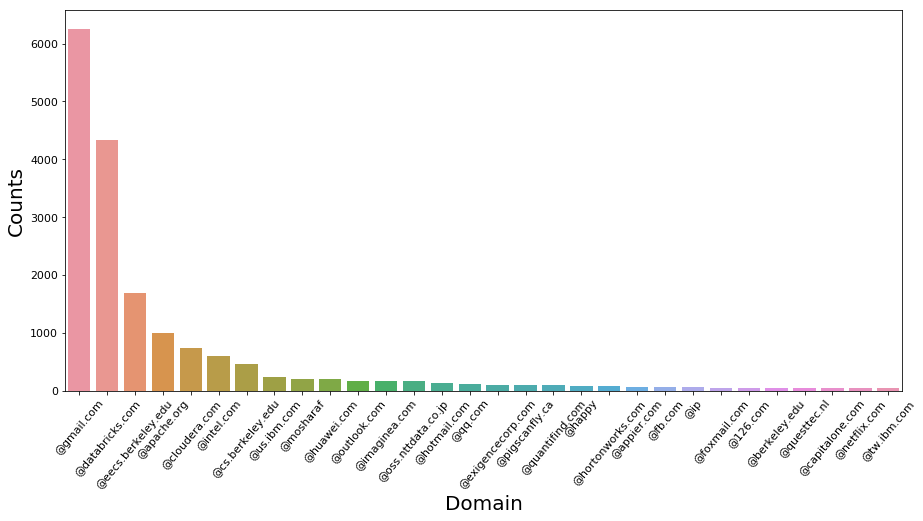

In [10]:
f, ax = plt.subplots(figsize=(15, 7))

# plot 30 most common email domains
g = sns.barplot(x=values,y=counts, ax=ax)
plt.xticks(rotation=50)
g.set_xlabel("Domain",fontsize=20)
g.set_ylabel("Counts",fontsize=20)
g.tick_params(labelsize=11)

<b>User activity investigation</b>

Text(0,0.5,'Count of commits')

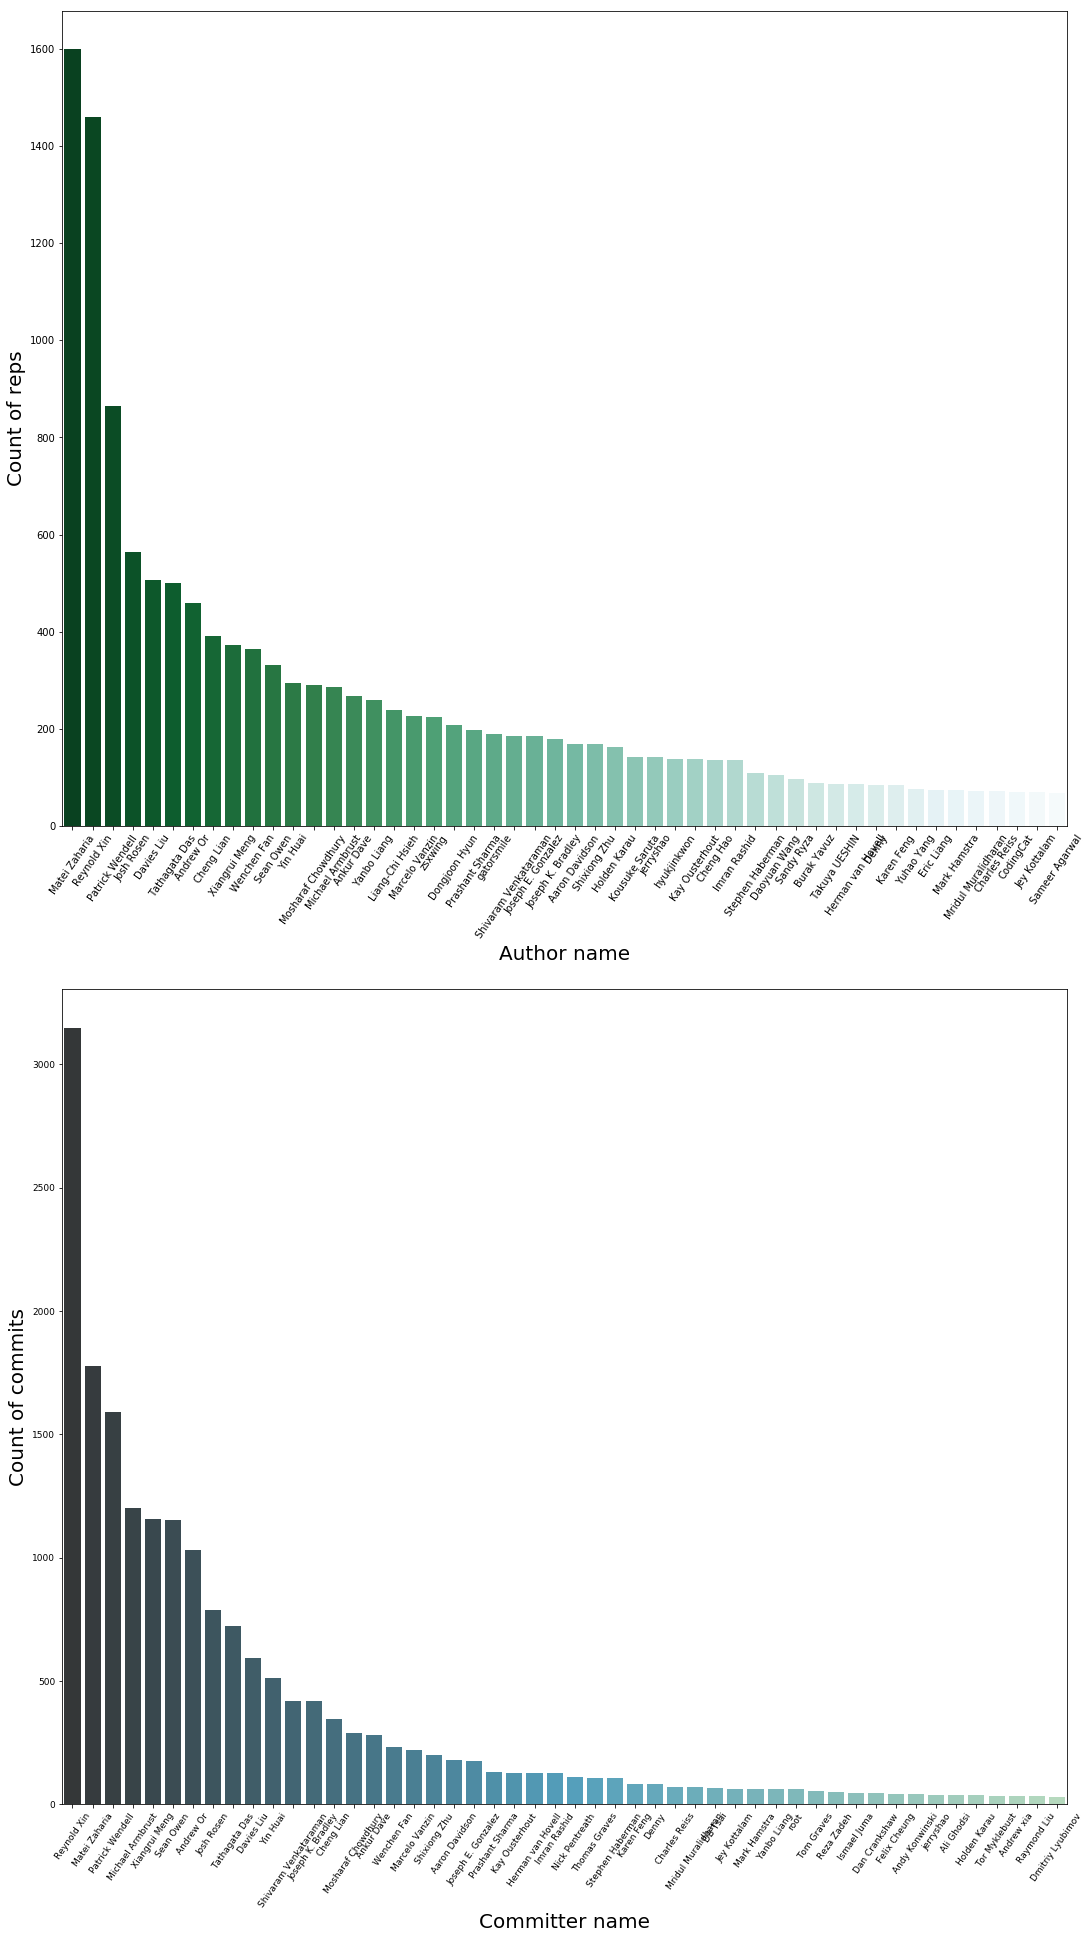

In [11]:
authors=dataset.author_name.value_counts()[:50] # take top 50 days
committers=dataset.committer_name.value_counts()[:50] # take top 50 days

f, (ax1,ax2) = plt.subplots(2,1,figsize=(18, 33))

# plot 60 most common authors
authors_name = authors.keys().tolist()
author_count = authors.tolist()

author_plot = sns.barplot(x=authors_name,y=author_count,palette='BuGn_r',ax=ax1)
author_plot.set_xticklabels(authors_name,rotation=55)
author_plot.tick_params(labelsize=10)
author_plot.set_xlabel("Author name",fontsize=20)
author_plot.set_ylabel("Count of reps",fontsize=20)

# plot 60 most common committers
committer_name = committers.keys().tolist()
committer_count = committers.tolist()

committer_plot = sns.barplot(x=committer_name,y=committer_count,palette='GnBu_d',ax=ax2)
committer_plot.set_xticklabels(committer_name,rotation=55)
committer_plot.tick_params(labelsize=9)
committer_plot.set_xlabel("Committer name",fontsize=20)
committer_plot.set_ylabel("Count of commits",fontsize=20)

There are users who are both authors and committers. The next step is to find them and see what their impact is.

In [12]:
auth_com = dataset.loc[dataset.author_name == dataset.committer_name]
authors_and_committers = auth_com.author_name.unique()
print('Number of authors + committers: ',len(authors_and_committers))

Number of authors + committers:  187


In [13]:
dataset_commits = dataset.shape[0]
auth_and_com = auth_com.shape[0]
print('All commits %r \nCommit as author: %r \nPercent of author commits: %.2f'%
      (dataset.shape[0],auth_and_com,auth_and_com/dataset_commits))

All commits 19226 
Commit as author: 9219 
Percent of author commits: 0.48


In [14]:
from datetime import datetime, timedelta

def convert_date(x):
    return datetime.fromtimestamp(x).strftime('%Y-%m-%d')

def convert_time(x):
    return datetime.fromtimestamp(x).strftime('%H:%M:%S')

def get_day(x):
    return datetime.fromtimestamp(x).weekday()

def get_year(x):
    return datetime.fromtimestamp(x).year

def get_month(x):
    return datetime.fromtimestamp(x).month

def previous_commit(x):
    previous_date = dataset.loc[(x.committer_name==dataset.committer_name)&(dataset.time<x.time)]
    if len(previous_date)==0: return -1
    return previous_date.iloc[-1].time

dataset = dataset.merge(dataset.apply(lambda x: pd.Series({'human_date':convert_date(x.time-x.time_offset), 
                                                           'human_time':convert_time(x.time-x.time_offset),
                                                           'day_of_week':get_day(x.time-x.time_offset),
                                                           'year':get_year(x.time-x.time_offset),
                                                           'month':get_month(x.time-x.time_offset),
                                                           'previous_commit':previous_commit(x)}), 
                                      axis=1), 
    left_index=True, right_index=True)

<b>Users and days with most actions</b>

In [15]:
user_actions = pd.DataFrame(dataset.groupby(['committer_name'])['human_date'].value_counts())
user_actions.human_date.sort_values(ascending=False)[:50] # take top 50 commit count

committer_name    human_date
Matei Zaharia     2013-07-05    36
Patrick Wendell   2013-06-22    32
Ankur Dave        2013-12-15    31
Ali Ghodsi        2013-08-21    27
Ankur Dave        2014-01-10    26
Jey Kottalam      2013-08-16    25
Patrick Wendell   2013-01-14    24
Matei Zaharia     2013-09-02    24
Ankur Dave        2014-01-11    23
jerryshao         2013-07-24    22
Reynold Xin       2014-01-14    22
                  2015-07-19    22
Matei Zaharia     2013-02-26    21
Raymond Liu       2014-01-03    21
Michael Armbrust  2014-12-17    20
Reynold Xin       2015-08-07    19
Matei Zaharia     2011-06-01    18
Patrick Wendell   2014-01-08    18
Ankur Dave        2014-01-14    17
Reynold Xin       2014-06-20    17
Matei Zaharia     2012-10-07    17
Andrew Or         2013-12-27    17
Ismael Juma       2011-05-27    17
Patrick Wendell   2014-01-14    16
Matei Zaharia     2013-01-21    16
Reynold Xin       2015-06-12    16
                  2015-05-31    16
Davies Liu        2015-07-

In [16]:
user_actions.mean()

human_date    2.597406
dtype: float64

<b> 60 days with most commits </b>

Text(0,0.5,'Count of commits')

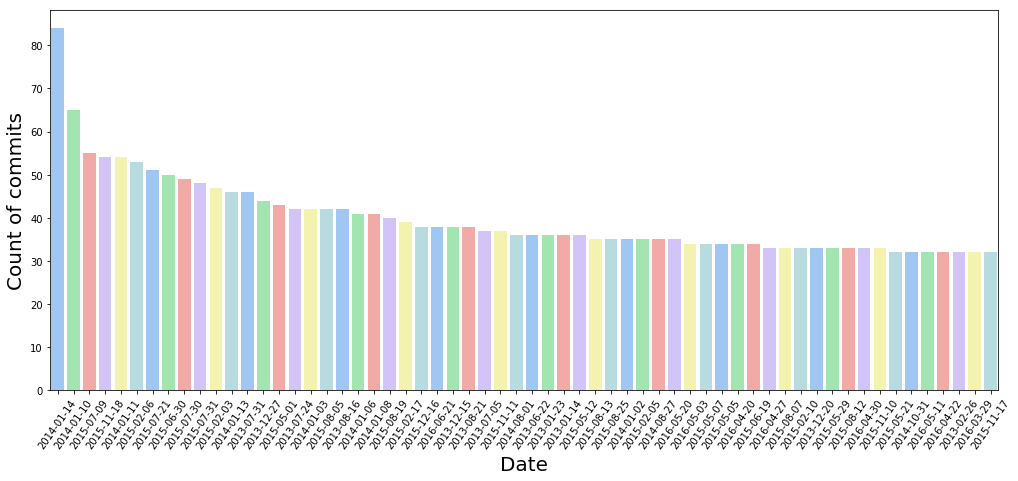

In [17]:
work = dataset.human_date.value_counts()[:60] # number of days
dates = work.keys().tolist()
commits = work.tolist()

f, ax = plt.subplots(figsize=(17, 7))

day_commits = sns.barplot(x=dates,y=commits,palette='pastel',ax=ax)
day_commits.set_xticklabels(dates,rotation=55)
day_commits.tick_params(labelsize=10)
day_commits.set_xlabel("Date",fontsize=20)
day_commits.set_ylabel("Count of commits",fontsize=20)

In [18]:
print('Mean commits per day: %.2f'%work.mean())

Mean commits per day: 39.87


# Investigating dataset missing values

In [19]:
dataset.isnull().sum()

author_name            0
author_email           0
committer_name         0
committer_email        0
time                   0
time_offset            0
message_encoding       0
severity            7751
human_date             0
human_time             0
day_of_week            0
year                   0
month                  0
previous_commit        0
dtype: int64

In [20]:
len(dataset.loc[dataset.severity.isna()])/dataset.shape[0]

0.4031519816914595

40% of our data has a NaN target. This is a significant amount, so let's try filling it in in a semi-supervised manner. But first we have to encode our categorical features.

# Feature encoding

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
names = dataset['author_name'].tolist()+dataset['committer_name'].tolist()
emails = dataset['author_email'].tolist()+dataset['committer_email'].tolist()

categories_names = LabelEncoder()
categories_names.fit(names)

dataset['author_name']=categories_names.transform(dataset['author_name'])
dataset['committer_name']=categories_names.transform(dataset['committer_name'])

categories_emails = LabelEncoder()
categories_emails.fit(emails)

dataset['author_email']=categories_emails.transform(dataset['author_email'])
dataset['committer_email']=categories_emails.transform(dataset['committer_email'])

# Text cleansing and encoding

In [23]:
dataset['message_encoding'] = messages

In [23]:
import re
def clean_text(text):
    text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace('```', '')
    text = re.sub(r'\[.*\]', '', text)
    text = text.replace(r'http\S+', '')
    text = text.replace('##', '')
    text = text.replace('```', '')
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = text.strip(' ')
    return text

dataset['message_encoding'] = dataset.message_encoding.apply(lambda x: clean_text(x))

In [24]:
dataset['message_encoding'][1200]

'add asynchronous actions documentation   what changes were proposed in this pull request?  add asynchronous actions documentation inside action of programming guide   how was this patch tested?  check the documentation indentation and formatting with md preview.  author: sandy <phalodi@gmail.com>  closes #14104 from phalodi/spark-16438.'

<b> Pipeline of CountVectorizer -> TfIdf to extract features from commit messages </b><br>
Also tried HashingVectorizer, but this pipeline yielded a better result.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline

In [26]:
text_encoding = Pipeline([
        ('count_vect',CountVectorizer(max_features=2000,stop_words='english')),
        ('tfidf',TfidfTransformer())
])
train_tf = text_encoding.fit_transform(dataset['message_encoding'])

# Train/test split

In [318]:
hv = HashingVectorizer(norm='l1',n_features=5000,stop_words='english')
train_tf = hv.transform(dataset.message_encoding)

In [351]:
train_tf.shape

(19226, 2000)

In [27]:
dataset_clean = dataset.drop(['message_encoding','human_date','human_time'],axis=1)

In [28]:
tfidf = pd.DataFrame(train_tf.todense())
dataset_clean_tf = dataset_clean.join(tfidf,how='left')

unlabeled = dataset_clean_tf.loc[dataset_clean_tf.severity.isna()]
dataset_clean_tf.dropna(inplace=True)
dataset_clean_tf.reset_index(inplace=True)
unlabeled.reset_index(inplace=True)

In [29]:
dataset_clean_tf.drop(['index'],axis=1,inplace=True)

In [30]:
from sklearn.model_selection import train_test_split

X,Y = dataset_clean_tf.drop(['severity'],axis=1), dataset_clean_tf.severity
unlabeled.drop(['severity'],axis=1,inplace=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Model selection with K-Fold cross-validation

In this model selecion, the models and architectures I'll use are: Random Forest, XGBoost, Decision Tree, Naive Bayes and a fully-connected Neural Network.

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import warnings
from xgboost import XGBClassifier

warnings.filterwarnings(action='ignore')

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

rfc = RandomForestClassifier(n_jobs=-1)
xgbc = XGBClassifier(n_jobs=-1,n_estimators=10) #limit to 10 because 100 trees is default and will take forever to run
dtc = DecisionTreeClassifier()
nbc = GaussianNB()

results_xgbc = cross_val_score(xgbc, X_train, Y_train, cv=kfold)
print("XGBoost: %.2f%% (%.2f%%)" % (results_xgbc.mean()*100, results_xgbc.std()*100))

results_rfc = cross_val_score(rfc, X_train, Y_train, cv=kfold)
print("Random Forest: %.2f%% (%.2f%%)" % (results_rfc.mean()*100, results_rfc.std()*100))

results_dtc = cross_val_score(dtc, X_train, Y_train, cv=kfold)
print("Decision Tree: %.2f%% (%.2f%%)" % (results_dtc.mean()*100, results_dtc.std()*100))

results_nbc = cross_val_score(nbc, X_train, Y_train, cv=kfold)
print("Gaussian Naive Bayes: %.2f%% (%.2f%%)" % (results_nbc.mean()*100, results_dtc.std()*100))

XGBoost: 58.01% (1.51%)
Random Forest: 56.28% (1.39%)
Decision Tree: 50.60% (2.02%)
Gaussian Naive Bayes: 54.62% (2.02%)


In [78]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
def build_model():
    model = Sequential()

    model.add(Dense(units=2048, activation='sigmoid', input_dim=2010))
    model.add(Dropout(0.5))
    model.add(Dense(units=2048, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(units=2048, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(units=5, activation='softmax'))
    
    opt= Adam(lr=4e-4,decay=1e-6)
    model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['acc'])

    return model

In [80]:
from keras.callbacks import EarlyStopping
stopper = EarlyStopping(min_delta=1e-5,patience=5,monitor='loss')

model = build_model()
model.fit(X_train, pd.get_dummies(Y_train),batch_size=128,epochs=15,callbacks=[stopper])

Epoch 1/15
7688/7688 [==============================] - 25s 3ms/step - loss: 1.4777 - acc: 0.4831
Epoch 2/15
7688/7688 [==============================] - 26s 3ms/step - loss: 1.3654 - acc: 0.4999
Epoch 3/15
7688/7688 [==============================] - 22s 3ms/step - loss: 1.3240 - acc: 0.5150
Epoch 4/15
7688/7688 [==============================] - 19s 3ms/step - loss: 1.2942 - acc: 0.5269
Epoch 5/15
7688/7688 [==============================] - 19s 3ms/step - loss: 1.2799 - acc: 0.5325
Epoch 6/15
7688/7688 [==============================] - 19s 3ms/step - loss: 1.2643 - acc: 0.5451
Epoch 7/15
7688/7688 [==============================] - 19s 2ms/step - loss: 1.2527 - acc: 0.5499
Epoch 8/15
7688/7688 [==============================] - 19s 3ms/step - loss: 1.2475 - acc: 0.5501
Epoch 9/15
7688/7688 [==============================] - 20s 3ms/step - loss: 1.2482 - acc: 0.5502
Epoch 10/15
7688/7688 [==============================] - 19s 3ms/step - loss: 1.2427 - acc: 0.5502
Epoch 11/15
7688/76

# Overview of model selection<br>

As expected, xgboost outperformed all algorithms, including a simple dense NN. Neural Networks will outperform any classical ML algorithms with the presence of a large dataset and resources to train it on. A train set of ~7.7k is not enough for a NN or any more advance layers. Although if there was enough data, I think something could be done with the use of LSTM on this kind of data.<br><br>
But <b>xgboost has outperformed every algorithm</b>, so it's time to move on to hyperparameter optimization.

# Hyperparameter optimization

In [34]:
#Baseline
from sklearn.metrics import accuracy_score
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=10, 
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    scale_pos_weight=1,
    seed=42)
xgb1.fit(X_train,Y_train)
accuracy_score(Y_test,xgb1.predict(X_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.5883284922101928

In [37]:
from sklearn.model_selection import GridSearchCV

param1 = {
 'max_depth':[5,10,20,40,60],
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator=XGBClassifier(
        learning_rate =0.1,
        n_estimators=10, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        n_jobs=-1, 
        scale_pos_weight=1, 
        seed=42), 
    param_grid = param1, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train,Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.58545, std: 0.00827, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.58298, std: 0.00638, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.58285, std: 0.00627, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.58415, std: 0.00760, params: {'max_depth': 10, 'min_child_weight': 1},
  mean: 0.58429, std: 0.00766, params: {'max_depth': 10, 'min_child_weight': 3},
  mean: 0.58532, std: 0.00741, params: {'max_depth': 10, 'min_child_weight': 5},
  mean: 0.58415, std: 0.00982, params: {'max_depth': 20, 'min_child_weight': 1},
  mean: 0.58480, std: 0.00794, params: {'max_depth': 20, 'min_child_weight': 3},
  mean: 0.58519, std: 0.00867, params: {'max_depth': 20, 'min_child_weight': 5},
  mean: 0.58311, std: 0.00927, params: {'max_depth': 40, 'min_child_weight': 1},
  mean: 0.58155, std: 0.00879, params: {'max_depth': 40, 'min_child_weight': 3},
  mean: 0.58038, std: 0.00901, params: {'max_depth': 40, 'min_child_weight': 5},
  mean: 0.57635, std: 0.00711, 

In [40]:
param2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[1,2]
}
gsearch2 = GridSearchCV(estimator=XGBClassifier(
        learning_rate =0.1,
        n_estimators=10, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        n_jobs=-1, 
        scale_pos_weight=1, 
        seed=42), 
    param_grid = param2, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train,Y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.58376, std: 0.00748, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.58415, std: 0.00732, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.58545, std: 0.00827, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.58480, std: 0.00757, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.58376, std: 0.00733, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.58350, std: 0.00862, params: {'max_depth': 6, 'min_child_weight': 2}],
 {'max_depth': 5, 'min_child_weight': 1},
 0.5854533871177907)

In [41]:
param3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator=XGBClassifier(
        learning_rate =0.1,
        n_estimators=10, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        n_jobs=-1, 
        scale_pos_weight=1, 
        seed=42), 
    param_grid = param3, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train,Y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.58545, std: 0.00827, params: {'gamma': 0.0},
  mean: 0.58545, std: 0.00827, params: {'gamma': 0.1},
  mean: 0.58545, std: 0.00827, params: {'gamma': 0.2},
  mean: 0.58571, std: 0.00840, params: {'gamma': 0.3},
  mean: 0.58558, std: 0.00792, params: {'gamma': 0.4}],
 {'gamma': 0.3},
 0.5857137192891033)

In [43]:
param4 = {
    'gamma':[0.25,0.3,0.35]
}
gsearch4 = GridSearchCV(estimator=XGBClassifier(
        learning_rate =0.1,
        n_estimators=10, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        n_jobs=-1, 
        scale_pos_weight=1, 
        seed=42), 
    param_grid = param4, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train,Y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.58532, std: 0.00824, params: {'gamma': 0.25},
  mean: 0.58571, std: 0.00840, params: {'gamma': 0.3},
  mean: 0.58545, std: 0.00816, params: {'gamma': 0.35}],
 {'gamma': 0.3},
 0.5857137192891033)

In [44]:
param5 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch5 = GridSearchCV(estimator=XGBClassifier(
        learning_rate =0.1,
        n_estimators=10, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0.3, 
        subsample=0.8, 
        colsample_bytree=0.8,
        n_jobs=-1, 
        scale_pos_weight=1, 
        seed=42), 
    param_grid = param5, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train,Y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.58259, std: 0.00906, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.58532, std: 0.00917, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.58324, std: 0.00853, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.58480, std: 0.00910, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.58480, std: 0.01057, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.58337, std: 0.00711, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.58454, std: 0.00688, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.58558, std: 0.00648, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.58428, std: 0.00774, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.58402, std: 0.00882, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.58571, std: 0.00840, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.58558, std: 0.00746, params: {'colsample_bytree': 0.8, 'subsample'

In [45]:
param6 = {
    'subsample':[0.9,0.925,0.95],
    'colsample_bytree':[0.9,0.925,0.95]
}
gsearch6 = GridSearchCV(estimator=XGBClassifier(
        learning_rate =0.1,
        n_estimators=10, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0.3, 
        subsample=0.8, 
        colsample_bytree=0.8,
        n_jobs=-1, 
        scale_pos_weight=1, 
        seed=42), 
    param_grid = param6, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch6.fit(X_train,Y_train)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.58636, std: 0.00725, params: {'colsample_bytree': 0.9, 'subsample': 0.9},
  mean: 0.58363, std: 0.00721, params: {'colsample_bytree': 0.9, 'subsample': 0.925},
  mean: 0.58363, std: 0.00768, params: {'colsample_bytree': 0.9, 'subsample': 0.95},
  mean: 0.58506, std: 0.00695, params: {'colsample_bytree': 0.925, 'subsample': 0.9},
  mean: 0.58389, std: 0.00767, params: {'colsample_bytree': 0.925, 'subsample': 0.925},
  mean: 0.58376, std: 0.00650, params: {'colsample_bytree': 0.925, 'subsample': 0.95},
  mean: 0.58519, std: 0.00691, params: {'colsample_bytree': 0.95, 'subsample': 0.9},
  mean: 0.58272, std: 0.00690, params: {'colsample_bytree': 0.95, 'subsample': 0.925},
  mean: 0.58311, std: 0.00838, params: {'colsample_bytree': 0.95, 'subsample': 0.95}],
 {'colsample_bytree': 0.9, 'subsample': 0.9},
 0.5863648460019443)

In [46]:
param_test7 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch7 = GridSearchCV(estimator=XGBClassifier(
        learning_rate =0.1,
        n_estimators=10, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0.3, 
        subsample=0.9, 
        colsample_bytree=0.9,
        n_jobs=-1, 
        scale_pos_weight=1, 
        seed=42), 
    param_grid = param_test7, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch7.fit(X_train,Y_train)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.58636, std: 0.00725, params: {'reg_alpha': 1e-05},
  mean: 0.58610, std: 0.00726, params: {'reg_alpha': 0.01},
  mean: 0.58376, std: 0.00853, params: {'reg_alpha': 0.1},
  mean: 0.58272, std: 0.00699, params: {'reg_alpha': 1},
  mean: 0.55021, std: 0.00054, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.5863648460019443)

In [47]:
param_test8 = {
    'reg_alpha':[1e-7,1e-6,1e-5]
}
gsearch8 = GridSearchCV(estimator=XGBClassifier(
        learning_rate =0.1,
        n_estimators=10, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0.3, 
        subsample=0.9, 
        colsample_bytree=0.9,
        n_jobs=-1, 
        scale_pos_weight=1, 
        seed=42), 
    param_grid = param_test8, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch8.fit(X_train,Y_train)
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.58636, std: 0.00725, params: {'reg_alpha': 1e-07},
  mean: 0.58636, std: 0.00725, params: {'reg_alpha': 1e-06},
  mean: 0.58636, std: 0.00725, params: {'reg_alpha': 1e-05}],
 {'reg_alpha': 1e-07},
 0.5863648460019443)

In [53]:
xgb_c = XGBClassifier(
    learning_rate =0.1,
    n_estimators=10, 
    max_depth=5,
    min_child_weight=1, 
    gamma=0.3, 
    subsample=0.9, 
    colsample_bytree=0.9,
    n_jobs=-1, 
    scale_pos_weight=1,
    reg_alpha=1e-07,
    seed=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
%timeit cross_val_score(xgb_c, X_train, Y_train, cv=kfold).mean()

26.3 s ± 530 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Tuning hyperparameters for text vectorization

First of all we have to remove the bad formatting and convert the commits to near clear text.

In [178]:
import re
def clean_text(text):
    text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace('```', '')
    text = re.sub(r'\[.*\]', '', text)
    #text = text.replace(r'http\S+', '')
    text = text.replace('##', '')
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    text = re.sub(r"\.",' ',text)
    text = re.sub(r"\(",' ',text)
    text = re.sub(r"\)",' ',text)
    text = re.sub(r"\/",' ',text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = text.strip(' ')
    return text
dataset['message_encoding'] = dataset.message_encoding.apply(lambda x: clean_text(x))

Now it's time to tune our text vectorizer by tuning the amount of features, n_grams and the use of idf on TfidfTransformer.
As text is our main set of features, we have to pay close attention to how these changes affect the model's result.

In [168]:
from sklearn.ensemble import RandomForestClassifier
text_encoding = Pipeline([
        ('vect',CountVectorizer(stop_words='english')),
        ('tfidf',TfidfTransformer()),
        ('rf',RandomForestClassifier(n_jobs=-1,n_estimators=15))
])

dataset_clean = dataset.dropna()
dataset_clean.reset_index(inplace=True)

param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2),(1,3),(2,1),(2,2),(3,1)],
    'tfidf__use_idf': (True, False),
    'vect__max_features': [1000,2000,3000]
}
grid_text = GridSearchCV(text_encoding, cv=4, n_jobs=-1, param_grid=param_grid)
grid_text.fit(dataset_clean['message_encoding'],dataset_clean['severity'])
grid_text.grid_scores_, grid_text.best_params_, grid_text.best_score_

([mean: 0.47678, std: 0.03885, params: {'tfidf__use_idf': True, 'vect__max_features': 1000, 'vect__ngram_range': (1, 1)},
  mean: 0.46431, std: 0.03331, params: {'tfidf__use_idf': True, 'vect__max_features': 1000, 'vect__ngram_range': (1, 2)},
  mean: 0.45264, std: 0.03387, params: {'tfidf__use_idf': True, 'vect__max_features': 1000, 'vect__ngram_range': (1, 3)},
  mean: 0.47503, std: 0.04255, params: {'tfidf__use_idf': True, 'vect__max_features': 1000, 'vect__ngram_range': (2, 1)},
  mean: 0.47983, std: 0.04788, params: {'tfidf__use_idf': True, 'vect__max_features': 1000, 'vect__ngram_range': (2, 2)},
  mean: 0.47259, std: 0.04188, params: {'tfidf__use_idf': True, 'vect__max_features': 1000, 'vect__ngram_range': (3, 1)},
  mean: 0.48270, std: 0.03991, params: {'tfidf__use_idf': True, 'vect__max_features': 2000, 'vect__ngram_range': (1, 1)},
  mean: 0.45987, std: 0.04352, params: {'tfidf__use_idf': True, 'vect__max_features': 2000, 'vect__ngram_range': (1, 2)},
  mean: 0.46292, std: 0.

In [29]:
text_encoding = Pipeline([
        ('vect',CountVectorizer(stop_words='english',max_features=3000,ngram_range=(3,1))),
        ('tfidf',TfidfTransformer(use_idf=False))
])
tf_train = text_encoding.fit_transform(dataset['message_encoding'])

In [51]:
dataset_clean = dataset.drop(['message_encoding','human_date','human_time'],axis=1)

tfidf = pd.DataFrame(tf_train.todense())
dataset_clean_tf = dataset_clean.join(tfidf,how='left')

unlabeled = dataset_clean_tf.loc[dataset_clean_tf.severity.isna()]
dataset_clean_tf.dropna(inplace=True)
dataset_clean_tf.reset_index(inplace=True)
unlabeled.reset_index(inplace=True)
dataset_clean_tf.drop(['index'],axis=1,inplace=True)

X,Y = dataset_clean_tf.drop(['severity'],axis=1), dataset_clean_tf.severity

unlabeled.drop(['severity'],axis=1,inplace=True)

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [33]:
xgb_c = XGBClassifier(
    learning_rate =0.1,
    n_estimators=120, 
    max_depth=5,
    min_child_weight=1, 
    gamma=0.3, 
    subsample=0.9, 
    colsample_bytree=0.9,
    n_jobs=-1, 
    scale_pos_weight=1,
    reg_alpha=1e-07,
    seed=42)

xgb_c.fit(X_train,Y_train)
accuracy_score(Y_test,xgb_c.predict(X_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.5941378399788751

Now that we have our text ready, all that's left is to try and boost our score with semi-supervised learning.

# Semi-supervised labeling

The point of this class is to train our model twice. The first time we train it to create labels for a part of our data that has NaN values. Then those training examples are added and the model is trained again on the bigger dataset.

In [56]:
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
class PseudoLabeler(BaseEstimator, RegressorMixin):
    
    def __init__(self, model, test, features, target, sample_rate=0.2, seed=42):
        self.sample_rate = sample_rate
        self.seed = seed
        self.model = model
        self.model.seed = seed
        
        self.test = test
        self.features = features
        self.target = target
        
    def get_params(self, deep=True):
        return {
            "sample_rate": self.sample_rate,
            "seed": self.seed,
            "model": self.model,
            "test": self.test,
            "features": self.features,
            "target": self.target
        }
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
        
    def fit(self, X, y):
        if self.sample_rate > 0.0:
            augemented_train = self.__create_augmented_train(X, y)
            self.model.fit(
                augemented_train[self.features],
                augemented_train[self.target]
            )
        else:
            self.model.fit(X, y)
        
        return self
    def __create_augmented_train(self, X, y):
        num_of_samples = int(len(self.test) * self.sample_rate)
        
        # Train the model and creat the pseudo-labels
        self.model.fit(X, y)
        pseudo_labels = self.model.predict(self.test[self.features])
        
        # Add the pseudo-labels to the test set
        augmented_test = self.test.copy(deep=True)
        augmented_test[self.target] = pseudo_labels
        
        # Take a subset of the test set with pseudo-labels and append in onto
        # the training set
        sampled_test = augmented_test.sample(n=num_of_samples)
        temp_train = pd.concat([X, y], axis=1)
        augemented_train = pd.concat([sampled_test, temp_train])
        return shuffle(augemented_train)
        
    def predict(self, X):
        return self.model.predict(X)
    
    def get_model_name(self):
        return self.model.__class__.__name__
    
    def feature_importances(self):
        return self.model.feature_importances_

In [44]:
semi_model = PseudoLabeler(
    XGBClassifier(
        learning_rate =0.1,
        n_estimators=120, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0.3, 
        subsample=0.9, 
        colsample_bytree=0.9,
        n_jobs=-1, 
        scale_pos_weight=1,
        reg_alpha=1e-07,
        seed=42
        ),
    unlabeled,
    X.columns,
    'severity',
    sample_rate=0.15
)

semi_model.fit(X_train,Y_train)
print("Accuracy on test dataset: %.4f " % accuracy_score(Y_test,semi_model.predict(X_test)))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



Accuracy on test dataset: 0.5960 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [54]:
final_classifier = PseudoLabeler(XGBClassifier(
        learning_rate =0.1,
        n_estimators=120, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0.3, 
        subsample=0.9, 
        colsample_bytree=0.9,
        n_jobs=-1, 
        scale_pos_weight=1,
        reg_alpha=1e-07,
        seed=42
        ),
    unlabeled,
    X.columns,
    'severity',
    sample_rate=0.2
)


final_classifier.fit(X_train,Y_train)
print("Accuracy on test dataset: %.4f " % accuracy_score(Y_test,final_classifier.predict(X_test)))

Accuracy on test dataset: 0.5984 


<b>Confussion matrix</b>

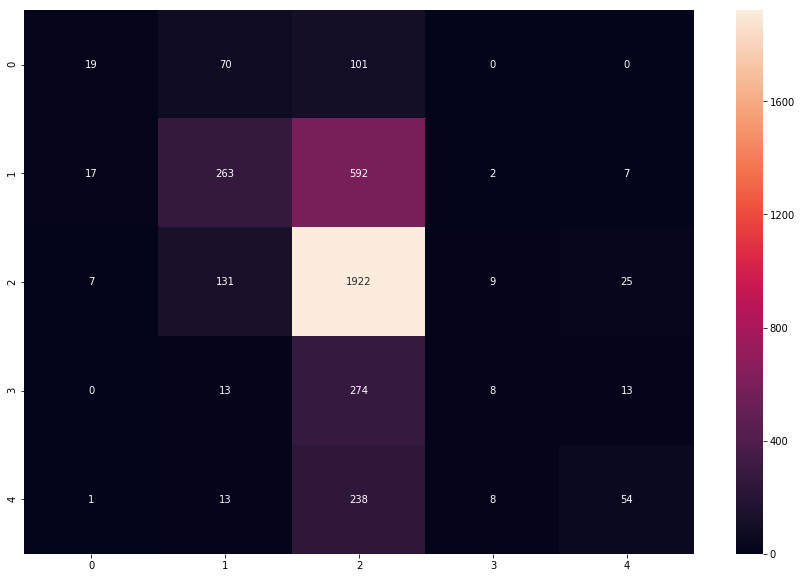

In [65]:
from sklearn.metrics import confusion_matrix
f, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(confusion_matrix(Y_test,final_classifier.predict(X_test)), annot=True, fmt="d")

# Conclusions and afterthoughts

<b><i>Algorithm overview</i></b><br><br>

The algorithms that were tried out are Gaussian Naive Bayes, Random Forest, XGBoost, Decision Tree and fully connected Neural Network. Altough I did try to use SVC, but the dimensionality is too big and it usually underperforms to other algorithms in high dimensions, so after 30 minutes of it running on my PC I turned it off.<br><br>

I think model results aren't surprising, because XGBoost has been on the rise for quite some time outperforming other ML algorithms. My reasoning on the subject of why it ourperformed every algorithm above is probably because it can 'evade' the dimensionality curse by not relying on any distance metric. Also the similarity between points is learned through adjustment of neighbors.<br><br>

Second runner up was Random Forest Classifier. I think that it should be possible to reach around 58% using it, and surely would've done so if only xgboost did not outperform so greatly. It is a powerful ensemble algrotithm nonetheless.<br><br>

Decision Trees are too simple for this task. A single tree can only go 3010 deep. They are usually used as some kind of baseline. Most of the time they are outperformed by Random Forest because it is simply a collection of Decision Trees.<br><br>

Naive Bayes surprised me with it's score being right behind Neural Networks. I think the main key point why it performs so good is because it generates conditional probabilities over data and every feature is taken as an independent variable, meaning that the algorithm takes every feature as it's own contribution to the prediction, which leads it to being regardless of any possible correlations between features. Our features are mostly extracted from text and this is where Naive Bayes shines.<br><br>

I think Neural Network is underrated here. Their overall possible effect is massive, and Deep Neural Networks outperform any algorithm here. The only problem with it is that our data is only ~7k samples on training, which is not even enough to see it ourperform everything. Things might've gone differently if all data was labeled.<br><br>

<b><i>Model and results overvies</i></b><br><br>
The final score after all text encoder's and xgboost tuning is <b>59.84</b>. We have a total of 5 classes, so a random model would've scored 0.2, which means that it surely has learned something.<br><br>
Looking at the confusion matrix we can see the disbalanced classes kick in. Nearly in every column majority of the wrong predictions are on '3', which has the most labeled classes.

In [66]:
Y_train.value_counts()

3.0     4230
1.0     1779
5.0      664
10.0     628
0.0      387
Name: severity, dtype: int64

Although if we take away all the false classification of $C_i,3$, then it would look more appealing. This is because the classes are heavily disbalanced. Balancing them would lead to a dataset of ~3k training samples and that would give a much worse result than this model. <br>
The main task here is to correctly extract data from text and cleanse it. This is a step that gives the biggest performance boost that all the tuning combined.<br><br>
Overall this task is very interesting and I would encourage people to try themselves out on this dataset and see what approaches they use in tackling this problem. I cannot say that I am pleased with these results, because there surely is room to improve on. I am genuinely interested in seeing how exactly a person with a score of >60 would tackle this problem and what their way of thinking about this task is.

<b> Thank you for this interesting task and hope to hear from you soon!</b></i>